<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/detection_retinanet_resnet152.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/detection_module.PNG)

# RetinaNet152 Based Detection Model
- This model can be used in two ways:
 - As a standalone model for Classification into Pneumonia/Not Pneumonia cases and Detection of Lung Opacities attributable to pneumonia.
 - As a final detection step in the two-step Option 1 Architecture explained earlier.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"



#Local Parameter Setup

In [ ]:
#Set global parameters here
BASE_MODEL = "Retinanet"
MODEL_NAME  = "/content/drive/My Drive/Option-1" + "." + BASE_MODEL
MODEL_BACKBONE = 'resnet152'
saved_model_file = MODEL_NAME + '/' + MODEL_BACKBONE+'model_2.h5'
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)

HISTORY_FILE = MODEL_NAME+"/" +"history.csv"
BATCH_SIZE = 32
IMAGE_SIZE = 256 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = True #True , change it to force training
EPOCHS = 14

In [ ]:
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
# baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
# print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
     |████████████████████████████████| 35.5MB 1.3MB/s 
/content


- Number of utility function are created for cross utilization accross all models. Main utility functions are listed below:
 - Model Training History Saving Function
 - History Plot Function
 -  Loads Preprocessed Data for EDA
 - Import Generic Model: with input_shape required, model name, last layer upto which retained etc. 
 - Split DataFrame
 - Balance DataFrame
 - Display Masked Images
 - Prediction Function
 - Training and Validation Data Generator
 - Mask Train Data Generator
 - Label Train Data Generator
 - Mask Test Data Generator
 - Label Test Data Generator
 - Loss Function
 - Test Mask Prediction
 - Test Class Label Prediction
 - RetinaNet Functions : To save? for evaluation of performance of the model. 
 - Written a function to show bounding boxes on the training dataset.?

#RetinaNet setup

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



 - We are checking the availibility of GPU as it is essential for training the RetinaNet model. We have also checked that there are no running processes. 

In [ ]:
#setup retinanet environment
os.chdir("/content/")
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 6150 (delta 6), reused 12 (delta 3), pack-reused 6114
Receiving objects: 100% (6150/6150), 13.48 MiB | 7.58 MiB/s, done.
Resolving deltas: 100% (4140/4140), done.


In [ ]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [ ]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=168078 sha256=0dcecf10e1e108797ea918bf01cf59948ff859de433da345702ff367f663caf0
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=ad545e7d21acf10b81874e6e6d63682ce5ec1bd461bd4ca6a8c1bdac457cfeac
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [ ]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [ ]:
# !pip install gdown
# !pip install tensorflow-gpu
# !ls
# !cd keras_retinanet/
# !ls

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 15, 7

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- We have downloaded the keras RetinaNet model utilities and imported required funcitions. 

# Prepare  Training Data

In [ ]:
# Load bounding boxes & merged data
oldPath = os.getcwd()
os.chdir(project_path)
meta_data, bbox_map, class_enc = loadData()

os.chdir(oldPath)

Loading full CXR info
Loading bbox map


In [ ]:
#cleare class encoding
classes = []
# classes.append('NO_PNEUMONIA')
classes.append('PNEUMONIA')
CLASSES_FILE = MODEL_NAME + '/classes.csv'
with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

In [ ]:
#create local copy for training
import shutil
shutil.copy(CLASSES_FILE, 'classes.csv')

'classes.csv'

- We created csv file containing the class Pneumonia marked as 0 which is required as input to the model.

In [ ]:
#utility function to convert dicom to jpeg
#genrate annotation file
#generate class file
import csv
import cv2
import gc
import os
gc.enable() #To enable garbage collection automatically
def convertToJpg(pn_df,annotationFile):
  # if (os.path.exists(annotationFile)):
  #   os.remove(annotationFile)
  csvFile = open(annotationFile, 'w', newline ='')
  csv_writer = csv.writer(csvFile, delimiter=',')
  folder = 'stage_2_train_images'
  folder_jpg = MODEL_NAME + '/' + folder
  if (os.path.isdir(folder_jpg) == False):
    os.mkdir(folder_jpg)
  folder_dcm = project_path + '/'+ folder
  i = 0;
  length = pn_df.shape[0]
  den= int(length/50)
  for n, row in pn_df.iterrows():
    if (i%den == 0):
      print("Converting jpg:{} of {}".format(i,length))
    i +=1
    
    pid = row['patientId']
    
    dcm_path = folder_dcm + '/' +pid +'.dcm'
    #Add csv annotation row for the image
    jpg_path = folder_jpg+'/'+pid +'.jpg'
    x1,x2,y1,y2= ['','','','']
    class_name = ''
    if pid in bbox_map:
      bboxes = bbox_map[pid].get('bboxes')
      for bb in bboxes:
        y, x, h, w = bb
        x1 = int(x)
        y1 = int(y)
        x2 = int(x1 + int(w))
        y2 = int(y1 + int(h))
        class_name = 'PNEUMONIA'
        csv_row = [jpg_path,x1,y1,x2,y2,class_name]
        csv_writer.writerow(csv_row)
    else:
      csv_row = [jpg_path,x1,y1,x2,y2,class_name]
      csv_writer.writerow(csv_row)
    #dump jpg if it does not exist
    if (os.path.exists(jpg_path) == False):
      # print(jpg_path)
      ds = pydicom.dcmread(dcm_path)
      pixel = ds.pixel_array
      cv2.imwrite(jpg_path,pixel)
      del ds

  csvFile.close()
  


- The above function converts DICOM files into jpg as RetinaNet requires image files in jpg format.
- The function also generates annotation file.

In [ ]:
# import pandas as pd
# target_csv = project_path +'/' + 'stage_2_train_labels.csv'
# df_target = pd.read_csv(target_csv)


In [ ]:
col = meta_data.columns[0]
if (col == 'Unnamed: 0'):
  meta_data.drop(col, inplace=True,axis=1)
meta_data.sample(3)


,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
10189,6d25fc2c-d0b3-4b4b-850f-dea71042576a,NaN,NaN,NaN,NaN,0,1,60,1,0,Normal,2,"[0.0, 0.0, 1.0]",stage_2_train_images/6d25fc2c-d0b3-4b4b-850f-d...
19102,b2541f48-1acf-4f33-b604-8665fc1517c8,179.0,581.0,169.0,183.0,1,2,59,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/b2541f48-1acf-4f33-b604-8...
25427,e3d0271b-b53f-4d6b-9e99-57fab7644798,NaN,NaN,NaN,NaN,0,1,32,1,1,Normal,2,"[0.0, 0.0, 1.0]",stage_2_train_images/e3d0271b-b53f-4d6b-9e99-5...


In [ ]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patientId     30227 non-null  object 
 1   x             9555 non-null   float64
 2   y             9555 non-null   float64
 3   width         9555 non-null   float64
 4   height        9555 non-null   float64
 5   Target        30227 non-null  int64  
 6   BboxNo        30227 non-null  int64  
 7   PatientAge    30227 non-null  int64  
 8   PatientSex    30227 non-null  int64  
 9   ViewPosition  30227 non-null  int64  
 10  class         30227 non-null  object 
 11  class_id      30227 non-null  int64  
 12  class_vector  30227 non-null  object 
 13  path          30227 non-null  object 
dtypes: float64(4), int64(6), object(4)
memory usage: 3.2+ MB


In [ ]:

#split the data
df_target = meta_data
raw_train_df,test_df = train_test_split(df_target, test_size=0.20, random_state=11,
                                    stratify=df_target['Target'])

In [ ]:
print(raw_train_df.shape, ':training data')
print(test_df.shape, ':test data')
print('{}: train PNEUMONIA'.format(raw_train_df[raw_train_df.Target == 1].shape))
print('{}: test PNEUMONIA'.format(test_df[test_df.Target == 1].shape))
print('{}: full PNEUMONIA'.format(df_target[df_target.Target == 1].shape))

(24181, 14) :training data
(6046, 14) :test data
(7644, 14): train PNEUMONIA
(1911, 14): test PNEUMONIA
(9555, 14): full PNEUMONIA


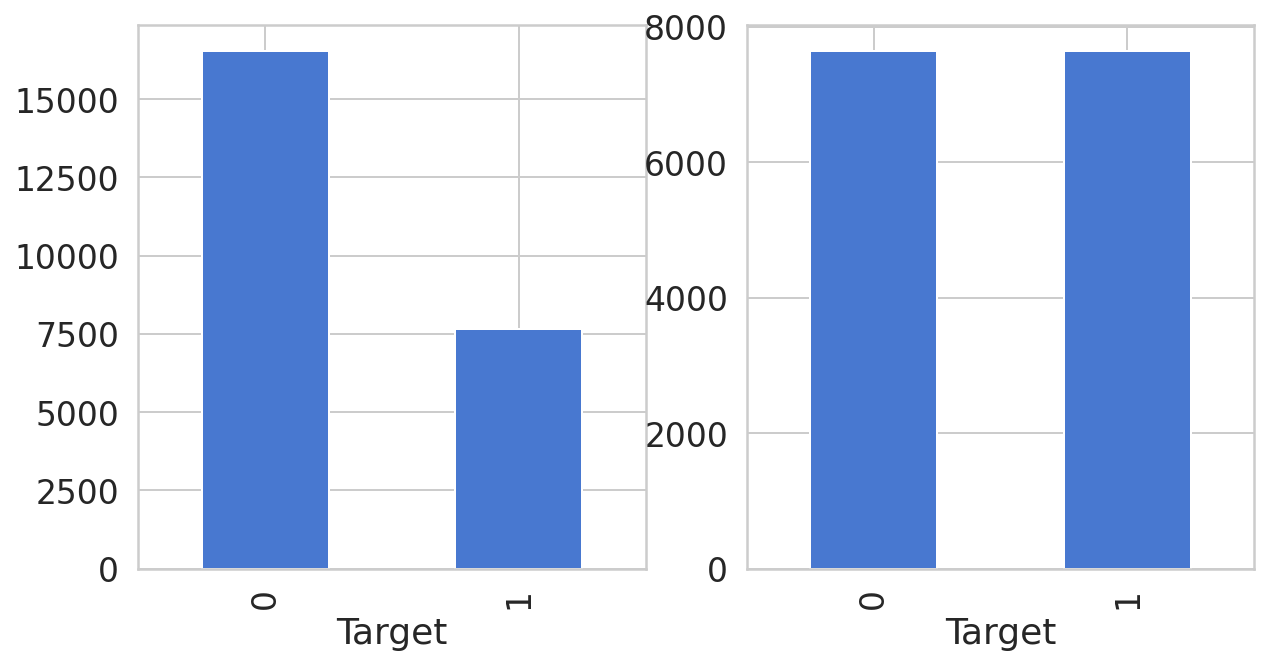

In [ ]:
train_df = balance_df(raw_train_df,15288)

- As could be seen from the first bar plot the target class is significantly imbalanced and the event to be predicted belongs to the minority class.
- The models are generally designed to improve accuracy by reducing the error.
- Accordingly, a classifier built tries to achieve higher overall accuracy as opposed to improving identification of the pneumonia cases, the minority target variable. 
- Hence, Model trained based on such imbalnaced data tend to produce unsatisfactory classifiers.
- In order to balance the dataset we have used the balance_df utility function specifically developed for proportionate representation of target variables. 

In [ ]:
%%time
os.chdir("/content/keras-retinanet")
#create annotation file & convert to JPEG
ANNOTATIONS_FILE = MODEL_NAME + '/annotations.csv'
if (os.path.isfile(ANNOTATIONS_FILE) == False):
  convertToJpg(train_df.sample(3000),ANNOTATIONS_FILE)

CPU times: user 0 ns, sys: 207 µs, total: 207 µs
Wall time: 446 µs


In [ ]:
shutil.copy(ANNOTATIONS_FILE, 'annotations.csv')

'annotations.csv'

In [ ]:
with open(ANNOTATIONS_FILE) as f: 
  cf = csv.reader(f) 
  for row in cf: 
    print(row)
    break

['/content/drive/My Drive/Option-1.Retinanet/stage_2_train_images/09460406-b734-43b0-8233-23055dea6dde.jpg', '', '', '', '', '']


In [ ]:
annot = pd.read_csv(ANNOTATIONS_FILE,header=None)
annot.columns = ["image_name","x_min","y_min","x_max","y_max","class_name"]

In [ ]:
annot.sample(5)

,image_name,x_min,y_min,x_max,y_max,class_name
3884,/content/drive/My Drive/Option-1.Retinanet/sta...,NaN,NaN,NaN,NaN,NaN
960,/content/drive/My Drive/Option-1.Retinanet/sta...,NaN,NaN,NaN,NaN,NaN
802,/content/drive/My Drive/Option-1.Retinanet/sta...,NaN,NaN,NaN,NaN,NaN
1991,/content/drive/My Drive/Option-1.Retinanet/sta...,NaN,NaN,NaN,NaN,NaN
3198,/content/drive/My Drive/Option-1.Retinanet/sta...,640.0,277.0,862.0,789.0,PNEUMONIA


- An annotation file in csv form containing path of the jpg images, bounding box details and target class is created for passing it through RetinaNet as input.

In [ ]:
annot.shape

(4175, 6)

In [ ]:
#display sample image
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()
  

In [ ]:
# pnu_annot = annot[annot.class_name == "PNEUMONIA"].sample(900)

# pnu_annot.x_min = pnu_annot.x_min.astype('int')
# pnu_annot.y_min = pnu_annot.y_min.astype('int')
# pnu_annot.x_max = pnu_annot.x_max.astype('int')
# pnu_annot.y_max = pnu_annot.y_max.astype('int')
# pnu_annot.to_csv('annotations.csv',index=False, header=None)

In [ ]:
# pnu_annot.info()

In [ ]:
index = annot[annot.class_name == "PNEUMONIA"].head().iloc[3]

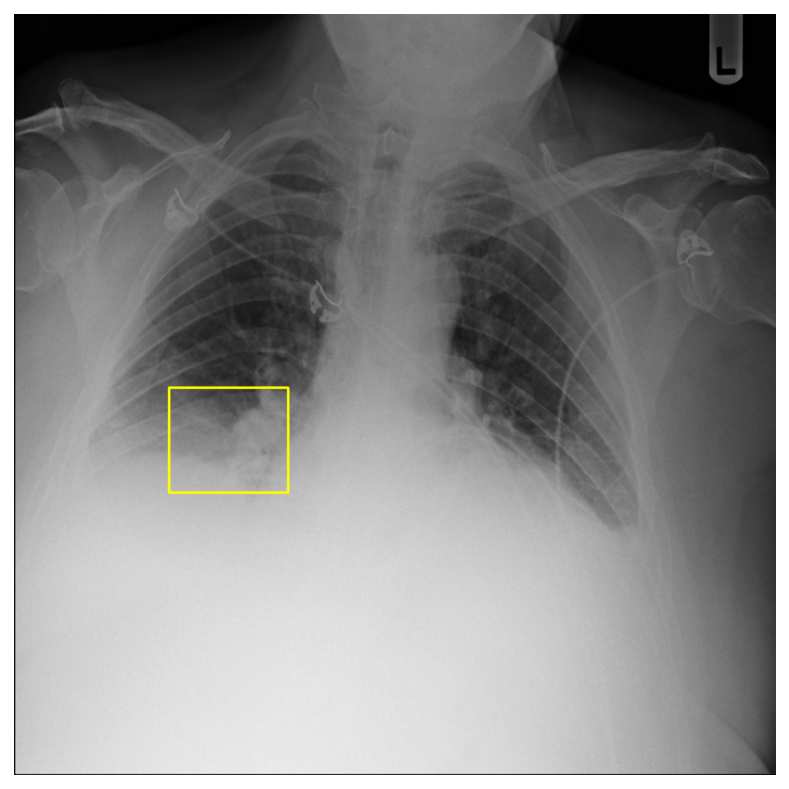

In [ ]:
show_image_objects(index)

#Training retinanet

In [ ]:
!retinanet-train --help

2020-09-28 05:15:26.819961: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
usage: retinanet-train [-h]
                       [--snapshot SNAPSHOT | --imagenet-weights | --weights WEIGHTS | --no-weights]
                       [--backbone BACKBONE] [--batch-size BATCH_SIZE]
                       [--gpu GPU] [--multi-gpu MULTI_GPU] [--multi-gpu-force]
                       [--initial-epoch INITIAL_EPOCH] [--epochs EPOCHS]
                       [--steps STEPS] [--lr LR]
                       [--optimizer-clipnorm OPTIMIZER_CLIPNORM]
                       [--snapshot-path SNAPSHOT_PATH]
                       [--tensorboard-dir TENSORBOARD_DIR]
                       [--tensorboard-freq TENSORBOARD_FREQ] [--no-snapshots]
                       [--no-evaluation] [--freeze-backbone]
                       [--random-transform] [--image-min-side IMAGE_MIN_SIDE]
                       [--image-max-side IMAGE_MAX_SIDE] 

In [ ]:
import urllib
snapshot = MODEL_NAME + '/MYSNAPSHOT'
if (os.path.isdir(snapshot) == False):
  os.makedirs(snapshot,exist_ok=True)
PRETRAINED_MODEL = snapshot + '/' + MODEL_BACKBONE +'.pretrained_model.h5'
# PRETRAINED_MODEL = snapshot + '/weights_1'+ '/' + 'resnet101_csv_06.h5'
if (os.path.isfile(PRETRAINED_MODEL) == False):
  print('Loading initial :',MODEL_BACKBONE)
# #### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
# # URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet101_oid_v1.0.0.h5'
  URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet152_oid_v1.0.0.h5'
  urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
#drive.mount('/content/gdrive')
#DRIVE_MODEL = '/content/gdrive/My Drive/Colab Notebooks/objdet_tensorflow_colab/resnet50_csv_10.h5'
PRETRAINED_MODEL_LOCAL = 'pretrained_model.h5'
# shutil.copy(WEIGHTS_FILE, PRETRAINED_MODEL_LOCAL)
shutil.copy(PRETRAINED_MODEL, PRETRAINED_MODEL_LOCAL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL_LOCAL)

Downloaded pretrained model to pretrained_model.h5


**RetinaNet Model Background**
-	Object detection is a tremendously important field in computer vision and is used in many applications including medical applications.
-	RetinaNet is one of the best one-stage object detection models that has proven to work well with dense and small-scale objects. The Network tackles efficiently the extreme foreground-background classes.
-	RetinaNet is a composite network composed of:
 - Backbone Network (i.e. Bottom-up pathway + Top down a pathway with lateral connections eg. ResNet + FPN).
 - Subnetwork for object Classification.
 - Subnetwork for object Regression.

**Bottom-up pathway:**

- Bottom-up pathway is used for feature extraction.
- Higher-level feature maps tend to have small resolution though semantically stronger. Therefore, more suitable for detecting larger objects.
- Grid cells from lower-level feature maps have high resolution and hence are better at detecting smaller objects.

**Top-down pathway:** 
-	Top-down pathway upsamples the spatially coarser feature maps from higher pyramid levels.

**Lateral Connections:**

-	The lateral connections merge the top-down layers and the bottom-up layers with the same spatial size.
-	With a combination of the top-down pathway and its lateral connections related to the bottom up pathway, every level of the resulting feature maps can be both semantically and spatially strong.
-	Hence this architecture is scale-invariant and can provide better performance both in terms of speed and accuracy.

**Subnetwork for object Classification**

-	A fully convolutional network (FCN) is attached to each Feature Pyramid Network (FPN) level for object classification.
-	The subnet consists of four 3×3 convolutional layers with 256 filters, followed by RELU activations. Then, another 3×3 convolutional layer with K×A filters are applied, followed by sigmoid activation. 
-	The subnet has shared parameters across all levels. 
-	The shape of the output feature map would be (W,H,KA), where W and H are proportional to the width and height of the input feature map, K and A are the numbers of object class and anchor boxes respectively.
-	The last Sigmoid layer is used for object classification.

**Subnetwork for object Regression**

-	The regression subnetwork is attached to each feature map of the FPN in parallel to the classification subnetwork. 
-	The design of the regression subnetwork is identical to that of the classification subnet, except that the last convolutional layer is of size 3x3 with 4+1 filters resulting in an output feature map with the size of WxHx(4+1)A. 
-	The subnetwork predicts 4+1 numbers for each anchor box in order to localize the object class. Therefore, the output feature map of the regression subnet has (4+1)A filters or channels. The first four are predicted bounding box coordinates. The additional 1 being the confidence score of having object within the predicted bounding box. 

**Focal Loss**

-	Focal Loss (FL) is an improved version of Cross-Entropy Loss (CE)  that tries to handle the class(foreground-background classes) imbalance problem by assigning more weights to hard or easily misclassified examples (i.e. background with noisy texture or partial object or the object of our interest )(In the current project , mainly misclassification of No Lung Opacity / Not Normal) and to down-weight easy examples (i.e. Background objects).
-	So Focal Loss reduces the loss contribution from easy examples and increases the importance of correcting misclassified examples. 

In general, ReitnaNet is a good choice for an object detection application.



**RetinaNet Model Implementation**
- One of the options implemented for detecting of opacity related to pneumonia is using RetinaNet based detector.
- In the process of building the model we have downloaded fizyr/keras-retinanet repository.
- Installed the keras-retinanet package locally on our computer.
- We have displayed above all the options available for training in keras-retinanet/models repository.

- We need input of annotations in the form of csv files for running the model. 
- The expected format of the files as input to the model are presented below and are already created.
 - A CSV file containing the path of jpg images, bounding box and classname of each image. 
 - The second CSV file should only contain the class name and their encoding.
 - The CSV file with annotations should contain one annotation per line. 
 - Images with multiple bounding boxes should use one row per bounding box. 
 - The indexing for pixel values to start at 0. 
 - There are images that do not contain any labeled objects. That is the images which are not pneumonia cases, where bounding box details are absent and target is 0. We need to add these images to the dataset as negative examples. This is done by adding an annotation where x1, y1, x2, y2 and class name are all empty.
 
 - Before training we have set the following:
 - Backbone architecture resnet152. 
 - freeze-backbone: Freezed the backbone layers. This is particularly useful to avoid overfitting when we use a small dataset.
 - weights: initialize the model with a pre-trained model (one released by Fizyr). It is better to start with a pre-trained model in lieu of training a model from scratch, which requires lot of computing resources and time.
 - random-transform: randomly transformed the dataset to get data augmentation.
 - Epochs: number of epochs to train. We have tried 3, 5, 10.. Higher the number of epochs better results observed.
 - We have trained with small dataset of 2,000 and also with large dataset of 10,000. The performance is better when we use larger dataset. But it takes arduously longer time to train.
 - When input image size is 256,  batch size could be set to 32. However, when image size is increased to 512, system becomes slow and ultimately throws out warning that memory is full. To continue our experimentation we reduced the batch size to 8 and trained the network.
 - batch-size: training batch size, the higher value has given a smoother learning curve.
 - steps: Number of steps for epochs(set at 500)
 - The learning rate is set to 0.0001 with patience of 2 and to reduce LR each time by 20%. 





In [ ]:
os.chdir("/content/keras-retinanet")

In [ ]:
WEIGHT_FILE = PRETRAINED_MODEL_LOCAL 
WEIGHT_FILE = 'snapshots/resnet152_csv_06.h5'


In [ ]:
%%time 
EPOCHS = 14
BATCH_SIZE =32

# if ((FORCE_TRAINING == True) | os.path.isfile(saved_model_file) == False):
  #back bone resnet101, resnet 152
  # batch size 16
  # --snapshot SNAPSHOT use this when to start training from here
  #--freeze-backbone --random-transform
  # --lr = 0.0001 --reduce-lr-patience =2 --reduce-lr-factor=0.2 epoch=6
  #  
                  #    --snapshot snapshots \
                  #  --initial-epoch 1 \
  # --lr 0.0001 --reduce-lr-patience 2 --reduce-lr-factor 0.2 \
  # !retinanet-train  --random-transform --snapshot snapshots --initial-epoch 3 --lr 0.0001 --reduce-lr-patience 2 --reduce-lr-factor 2 --backbone resnet101 --freeze-backbone  --weights {WEIGHT_FILE} --batch-size 32  --steps 600 --epochs 5 --image-max-side 512 --workers 6 --multiprocessing    csv annotations.csv classes.csv
!retinanet-train   --weights {WEIGHT_FILE} \
                   --lr 0.0001 --reduce-lr-patience 2 --reduce-lr-factor 0.2 \
                   --backbone resnet152 --freeze-backbone  \
                   --batch-size {BATCH_SIZE} \
                   --steps 500 --epochs {EPOCHS} \
                   --image-max-side {IMAGE_SIZE} \
                   --workers 6 --multiprocessing \
                   csv annotations.csv classes.csv

500/500 [==============================] - ETA: 0s - loss: 0.9085 - regression_loss: 0.7045 - classification_loss: 0.2040
Epoch 00003: saving model to ./snapshots/resnet152_csv_03.h5
500/500 [==============================] - 437s 874ms/step - loss: 0.9085 - regression_loss: 0.7045 - classification_loss: 0.2040
Epoch 4/14
500/500 [==============================] - ETA: 0s - loss: 0.6918 - regression_loss: 0.5436 - classification_loss: 0.1482
Epoch 00004: saving model to ./snapshots/resnet152_csv_04.h5
500/500 [==============================] - 434s 869ms/step - loss: 0.6918 - regression_loss: 0.5436 - classification_loss: 0.1482
Epoch 5/14
500/500 [==============================] - ETA: 0s - loss: 0.5427 - regression_loss: 0.4373 - classification_loss: 0.1054
Epoch 00005: saving model to ./snapshots/resnet152_csv_05.h5
500/500 [==============================] - 442s 884ms/step - loss: 0.5427 - regression_loss: 0.4373 - classification_loss: 0.1054
Epoch 6/14
500/500 [===================

# Inference

In [ ]:
!ls snapshots

In [ ]:
# src = './snapshots'
# if (os.path.isdir(src)):
#   dst = snapshot + '/' + 'weights_1'
#   shutil.copytree(src, dst)

In [ ]:
# model = models.load_model('/content/drive/My Drive/Option-1.Retinanet/model.h5')
# model.summary()

In [ ]:
model = 0
os.chdir("/content/keras-retinanet")
FORCE_TRAINING = False
if ((FORCE_TRAINING == False) & os.path.isfile(saved_model_file)):
# if (False):
  print("Loading saved model")
  model = models.load_model(saved_model_file)
  model.summary()
  print('Model Loading done')
else:
  model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
  # model_path = WEIGHTS_FILE
  print(model_path)

  model = models.load_model(model_path, backbone_name='resnet101')
  model = models.convert_model(model)
  print("Saving model at:",saved_model_file)
  model.save(saved_model_file)
  print('Model saving done')

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

Loading saved model
Model: "retinanet-bbox"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
_________________________________________________________________

In [ ]:

# #del model
# model = models.load_model('/content/drive/My Drive/Option-1.Retinanet/model.h5')

In [ ]:
annot[annot.class_name == 'PNEUMONIA'].head().iloc[0].image_name

'/content/drive/My Drive/Option-1.Retinanet/stage_2_train_images/a20c1c8f-e16e-440b-89d0-2393ea43b340.jpg'

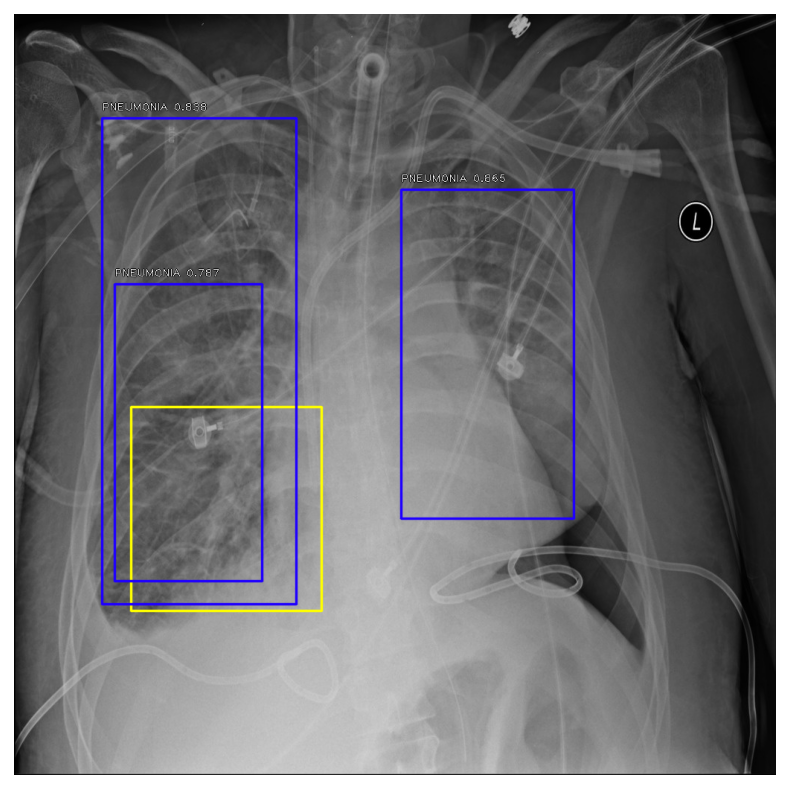

In [ ]:
THRES_SCORE=0.3
oldPath = os.getcwd()
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
folder = 'stage_2_train_images'
# dcm_path = folder + '/' + 'cd1d42a0-e085-4f64-baaf-1da212416e8d.dcm'
# dcm_path = folder + '/' + '378ef52a-cbc7-4e92-bd6b-ecb4045508f3.dcm'
dcm_path = folder + '/' + 'b8a633b3-b2fa-4e17-be54-faf0aba4c903.dcm'
show_detected_objects(dcm_path,bbox_map,model)
os.chdir(oldPath)

#Performance -Score/NMS filtering

In [ ]:
test_df.head(1)

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
18993,b18e9b1c-e430-4200-8553-e585e0c49afc,NaN,NaN,NaN,NaN,0,1,43,1,0,Normal,2,"[0.0, 0.0, 1.0]",stage_2_train_images/b18e9b1c-e430-4200-8553-e...


In [ ]:
%%time
os.chdir(project_path)
iou = 0.3
THRES_SCORE=0.3

sample = test_df.sample(3000)
no_test = sample.shape[0]
pred_file = MODEL_NAME + '/prediction.' +MODEL_BACKBONE +'.'+str(iou)+ str(no_test) +'.csv'
FORCE_PREDICTION = False;
pred_test_df = pd.DataFrame()
pred_test_df = 0
test_y = 0;
pred_y = 0
if ((os.path.isfile(pred_file) == False) | (FORCE_PREDICTION)):
  print('Predicting on test dataframe')
  #Pass test dataframe, bouding box map, trained mode, file to dump prediction, IoU threshold
  
  pred_test_df,test_y,pred_y = doRetinaPrediction(sample,bbox_map,model,pred_file,iou)
else:
  pred_test_df = pd.read_csv(pred_file)
  test_y = pred_test_df["Target"]
  pred_y = pred_test_df["predTarget"]

Generating prediction:2730 of 3000
Generating prediction:2760 of 3000
Generating prediction:2790 of 3000
Generating prediction:2820 of 3000
Generating prediction:2850 of 3000
Generating prediction:2880 of 3000
Generating prediction:2910 of 3000
Generating prediction:2940 of 3000
Generating prediction:2970 of 3000
Prediction Complete!
CPU times: user 4min 21s, sys: 10.5 s, total: 4min 32s
Wall time: 21min 47s


- To perform object detection on an image we need to convert the trained model to an inference model.
- The input sample dicom image is temporarily converted to jpg and resized. 
- The resized jpg image is used for model prediction of bounding box, confidence and classification.
- After the prediction is completed the jpg file so converted is deleted to avoid cluttering.
- Once the prediction process is complete the image is resized to original size. 
- It is pertinent to highlight that RetinaNet utility allows us to display only one ground truth bounding box per image. **We have developed an utility which allows us to display multiple ground truth bounding boxes per image.**
- The draw detection functionality suppresses  the bounding boxes which are below the specified threshold confidence score. 

In [ ]:
len(pred_test_df[pred_test_df.predTarget == 1])

1240

In [ ]:
pred_test_df.head(10)

,patientId,x,y,width,height,Target,x_pred,y_pred,width_pred,height_pred,predTarget,iou,confidence
0,ab1131b2-d179-4087-b32b-463a3e615ba6,296,297,186,181,1,236,186,243,287,1,0.452366,0.476281
1,ab1131b2-d179-4087-b32b-463a3e615ba6,606,256,235,355,1,634,268,204,307,1,0.750710,0.988298
2,05b22cd6-c876-4360-8361-92845c6de8ba,124,409,230,212,1,0,0,0,0,0,0.000000,0.300000
3,05b22cd6-c876-4360-8361-92845c6de8ba,572,453,229,205,1,553,331,208,256,1,0.338280,0.909409
4,177423d8-e811-4fd7-bfba-6b77b479e466,272,464,225,291,1,0,0,0,0,0,0.000000,0.300000
5,0e63cd8d-3f26-4f6f-b202-683e747d3458,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
6,8a38f81b-8ab1-4ea6-906c-5d803833ffdb,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
7,43e034fb-4f9c-4c7e-ae46-abfee29fbc22,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
8,d176bc03-d080-4f59-8d1d-1fad98affb90,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
9,0b8ba576-7734-4192-ba1b-5618dd257f6b,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000


In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(test_y, pred_y), "\n")
print("Classification Report:- \n", metrics.classification_report(test_y, pred_y))

Confusion Matrix:- 
 [[2058    0]
 [ 602 1240]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.77      1.00      0.87      2058
           1       1.00      0.67      0.80      1842

    accuracy                           0.85      3900
   macro avg       0.89      0.84      0.84      3900
weighted avg       0.88      0.85      0.84      3900



In [ ]:
filtered_df = pred_test_df.groupby('patientId').apply(lambda x: x[x.predTarget == 1].sample(1) if (x.predTarget.any()) else x.sample(1))

In [ ]:
f_test_y = filtered_df["Target"]
f_pred_y = filtered_df["predTarget"]

In [ ]:
f_test_y = f_test_y.apply(int)
f_pred_y = f_pred_y.apply(int)

In [ ]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(f_test_y, f_pred_y), "\n")
print("Classification Report:- \n", metrics.classification_report(f_test_y, f_pred_y))

Confusion Matrix:- 
 [[2058    0]
 [ 259  640]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      2058
           1       1.00      0.71      0.83       899

    accuracy                           0.91      2957
   macro avg       0.94      0.86      0.89      2957
weighted avg       0.92      0.91      0.91      2957



In [ ]:
pred_y = filtered_df.confidence.apply(float).to_numpy()

In [ ]:
pred_y

array([0.35550258, 0.97610235, 0.3       , ..., 0.3       , 0.80399305,
       0.70239043])

In [ ]:
y_test = f_test_y.to_numpy()

In [ ]:
y_test

array([1, 1, 0, ..., 0, 1, 1])

Text(0.5, 1.0, 'Lung Opacity ROC Curve')

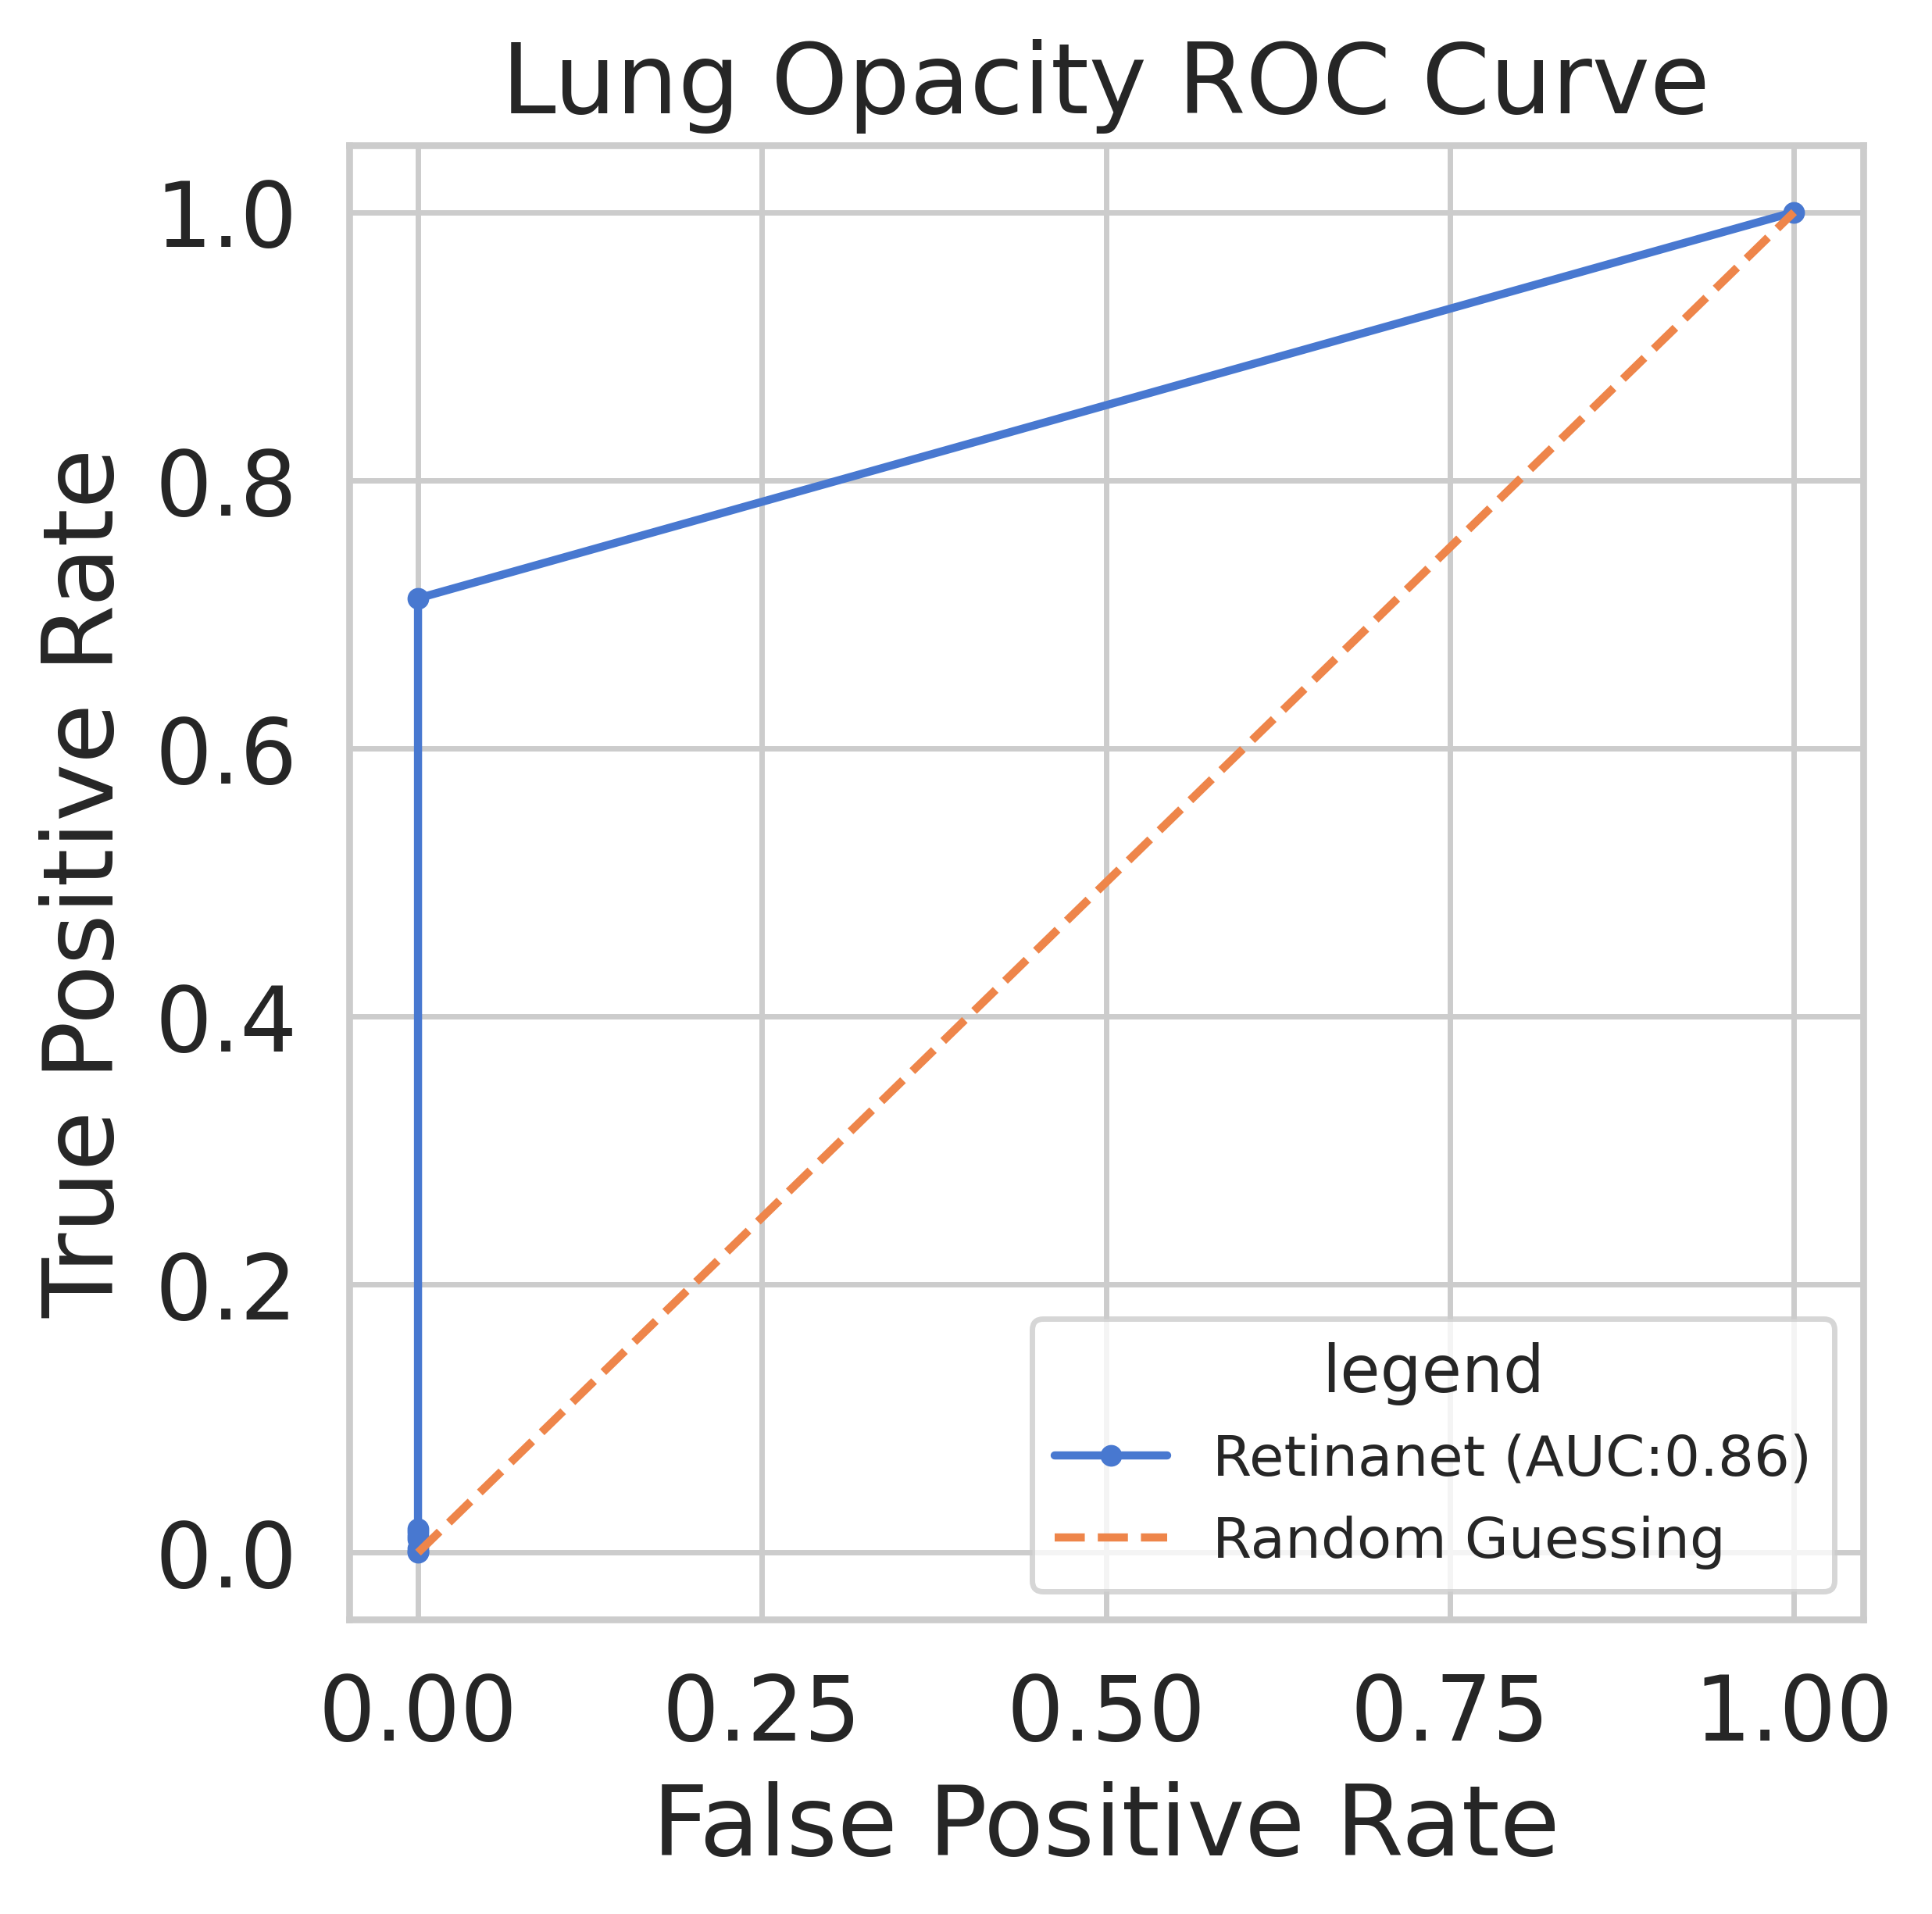

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('xx-small')
fpr, tpr, _ = roc_curve(y_test, pred_y)
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 250)
ax1.plot(fpr, tpr, marker='.', label = 'Retinanet (AUC:%2.2f)' % roc_auc_score(y_test, pred_y))
ax1.plot(fpr, fpr, linestyle='--', label = 'Random Guessing')
ax1.legend(title='legend',  loc='lower right', prop=fontP)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')

**Challenges faced during the implementation of RetinaNet**
- As RetinaNet doesnot accept DICOM files and requires image files in the form of jpg or png we were faced with task of converting the DICOM files into jpg. Apart from time to learn how to convert we had to invest lot of time for converting all the images. 
- The RetinaNet requires certain specific pretraining steps like input of annotation in csv file containing image path, bounding box coordinates(X_min, Y_min, X_max, Y_max(not width and height) and target class label. It also presupposes availibility of another csv file containing class label with corresponding encoding. 
- All these specific steps are alien to us and the team had to refer and understand these nitty-gritties before implementation of the model.
- RetinaNet is complex model to understand we had to refer many articles and search net a lot to get an understanding of the overall function of the model.
- Other challenges included fine tuning the model hyperparameters such as image size, batch size, step size, learning rate, learning rate decay, image augmentation, pretraining with the transfer learning weights and also further training with last saved best weights. 
- Converting the train model to inference model for prediction.



**Conclusion**

- We went through the complete implementation journey to develop a pneumonia opacity detector using RetinaNet. 
-	We created a dataset, trained a model, and ran inference.
-	RetinaNet is a powerful model that uses Feature Pyramid Networks & ResNet as its backbone. 
-	We were able to get decent results for detector of opacity attributed pneumonia with very limited dataset & very few epochs (6 epochs with 500 steps each) only. 
- We can change the threshold value to identify the suitable threshold required to be set.

**End Note:** 
- If we train our model at least for 20 epochs we would get better results.
-	Our main idea is to showcase the approach to build pneumonia related opacity detector using the RetinaNet model. 
-	We can tweak the model further and use more data to train to get better results to take it forward for live implementation. 
-	RetinaNet showed both good accuracy and speed compared to other detectors while still keeping a very simple construct.


# **Pickling**

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
class PreProcessing(BaseEstimator, ClassifierMixin):
  def __init__(self):
    self.isDcmFile = True
    pass
  def fit(self, dataset, y=None):
    return self
  def setupRetina(self):
    import os
    olddir = os.getcwd()
    os.chdir("/content/")
    !git clone https://github.com/fizyr/keras-retinanet.git
    !pip install --upgrade keras
    %cd keras-retinanet/
    !pip install .
    !python setup.py build_ext --inplace
    !pip install pydicom
    os.chdir(olddir)
  def setupImport(self):
    import numpy as np;global np
    import tensorflow as tf;global tf
    import pandas as pd;global pd
    import seaborn as sns;global sns
    from pylab import rcParams;global rcParams
    import matplotlib.pyplot as plt;global plt
    from matplotlib import rc;global rc
    from pandas.plotting import register_matplotlib_converters;global register_matplotlib_converters
    from sklearn.model_selection import train_test_split;global train_test_split
    import urllib;global urllib
    import os;global os
    import csv;global csv
    import cv2;global cv2
    import time;global time
    from PIL import Image;global Image

    from keras_retinanet import models;global models
    from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
    global read_image_bgr, preprocess_image, resize_image
    from keras_retinanet.utils.visualization import draw_box, draw_caption
    global draw_box, draw_caption
    from keras_retinanet.utils.colors import label_color;global label_color


    %matplotlib inline
    %config InlineBackend.figure_format='retina'

    register_matplotlib_converters()
    sns.set(style='whitegrid', palette='muted', font_scale=1.5)

    rcParams['figure.figsize'] = 15, 7

    RANDOM_SEED = 42

    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)
    import pydicom;global pydicom
    
  def setup(self):
    self.setupRetina()
    self.setupImport()
  def setXrayType(self,isDcm):
    self.isDcmFile = isDcm
  def transform(self, X):
    print("Calling PreProcessing transform ")
    
    return self.get_image(X,self.isDcmFile)
  def get_image(self,dcm_path,isDcm=True):
  # img_path = image_row.image_name
    jpg_path = dcm_path
    if (isDcm):
      ds = pydicom.dcmread(dcm_path)
      pixel = ds.pixel_array
      # get filename without extension
      file = dcm_path.split('/')
      file = file[len(file)-1]
      patient = file.split('.')[0]
      # print(patient)
      jpg_path = patient + '.jpg'
      cv2.imwrite(jpg_path,pixel)
      del pixel
     
    image = read_image_bgr(jpg_path)
    if (isDcm):
      os.remove(jpg_path)
  
    return image

- This is the preprocessing class of the pipeline
- We have also given API(setXrayType) to configure whether the input passed is DICOM or JPG. For DICOM user should pass True value and for JPG pass False value.

In [ ]:

class FinalEstimator(BaseEstimator, ClassifierMixin):
  def loadModel(self,path,classFile = None):
    if (os.path.isfile(path)):
      print("Loading saved model")
      self.mymodel = models.load_model(path)
      
      # model.summary()
      print('Model Loading done')
    else:
      print("Model loading failed")
    if (classFile is not None):
      self.labels_to_names = pd.read_csv(classFile, header=None).T.loc[0].to_dict()
  def setModel(self,model):
     self.mymodel =  model 
  def resetModel(self):
    self.mymodel = 0
  def __init__(self):
    pass
    
  def fit(self, dataset, y=None):

    return self
  def retina_predict(self,image):
    # print(image.shape)
    image = preprocess_image(image.copy())
    image, scale = resize_image(image,min_side=255,max_side=255)
    # image, scale = resize_image(image)
    # print(image.shape)
    boxes, scores, labels = self.mymodel.predict_on_batch(np.expand_dims(image, axis=0))

    boxes /= scale

    return boxes, scores, labels
  def draw_detections(self,image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
      if score < 0.35:
        break
    # print(box)
      color = label_color(label)

      b = box.astype(int)
      draw_box(image, b, color=color)

      caption = "{} {:.3f}".format(self.labels_to_names[label], score)
      draw_caption(image, b, caption)
  def predict(self,X):
    print("Predicting using custom predictor:")
    boxes, scores, labels = self.retina_predict(X)
    draw = X.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    self.draw_detections(draw, boxes, scores, labels)
    plt.axis('off')
    plt.imshow(draw)
    plt.show()
    return 1

- This is the Final Estimator which does the final prediction of the image using predict of the image. 
- In case of user wants to train further on new data received in due course, we can activate the fit function provided. 

In [ ]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('preprocessing', PreProcessing()), ('retina', FinalEstimator())])
pipe[1].loadModel(saved_model_file,CLASSES_FILE)


Loading saved model
Model Loading done


- This pipeline has two stages.  
 - First stage named as 'preprocessing' takes DICOM/JPG image and converts it into 256x256 and preprocesses it as required for subsequent layer. The input to this model will be from stage 1 for jpg case or from stage 2 for DICOM case which can be set as required. 
 - In case the user wants to use the RetinaNet model as an indepent model without stage 1 or stage 2, the input of the DICOM or JPG needs to be passed directly to the pipeline.predict function.
- In second stage named as 'retinal', the pipeline automatically takes the preproccesed pixel values and the RetinNet predicts bounding box, confidence socre and predicted label. It also displays the image with detected opacity location attributed to pneumonia case.

In [ ]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
annot[annot.class_name == "PNEUMONIA"].head().iloc[1].image_name

'/content/drive/My Drive/Option-1.Retinanet/stage_2_train_images/a20c1c8f-e16e-440b-89d0-2393ea43b340.jpg'

In [ ]:
#Setting image type
pipe[0].setXrayType(False)
jpg_path = '/content/drive/My Drive/Option-1.Retinanet/stage_2_train_images/a20c1c8f-e16e-440b-89d0-2393ea43b340.jpg'

In [ ]:
print(os.getcwd())
pipe.fit(jpg_path)

/content/drive/My Drive/rsna-pneumonia-detection-challenge
Calling PreProcessing transform 


Pipeline(memory=None,
         steps=[('preprocessing', PreProcessing()),
                ('retina', FinalEstimator())],
         verbose=False)

Calling PreProcessing transform 
Predicting using custom predictor:


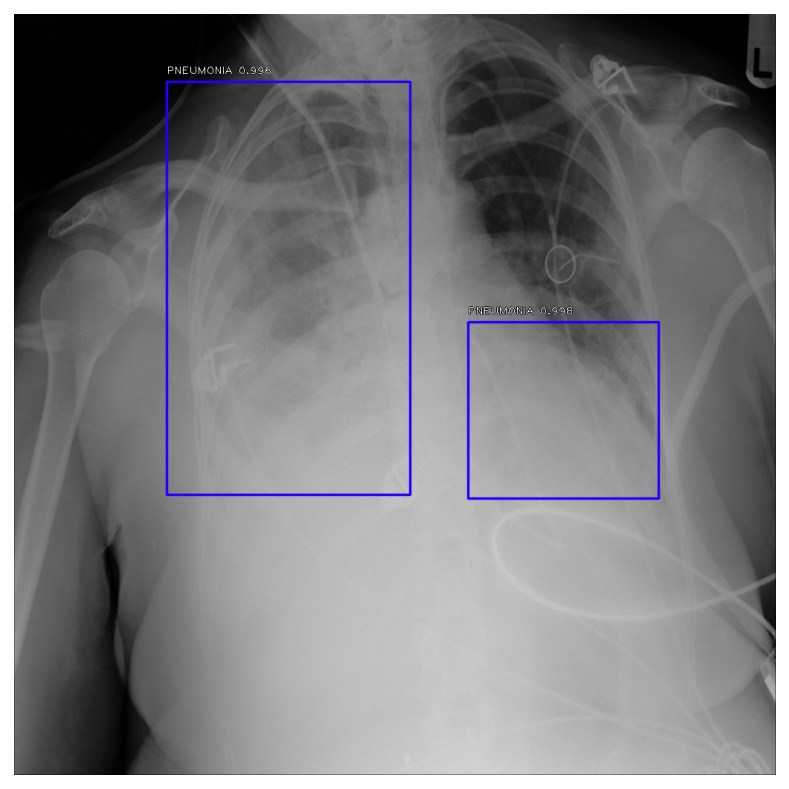

1

In [ ]:

pipe.predict(jpg_path)

- In the above to cells we are just checking the pipline functioning.

In [ ]:
# Use pickle to save model for next usage.
import dill
pipe[1].resetModel()
filename = 'model_v1.pk'

with open('./'+filename, 'wb') as file:
    dill.dump(pipe, file) 

- At this stage we are creating the pickle file of the prediction pipline as an interim user interface. 

Loading saved model
Model Loading done
Calling PreProcessing transform 
Predicting using custom predictor:


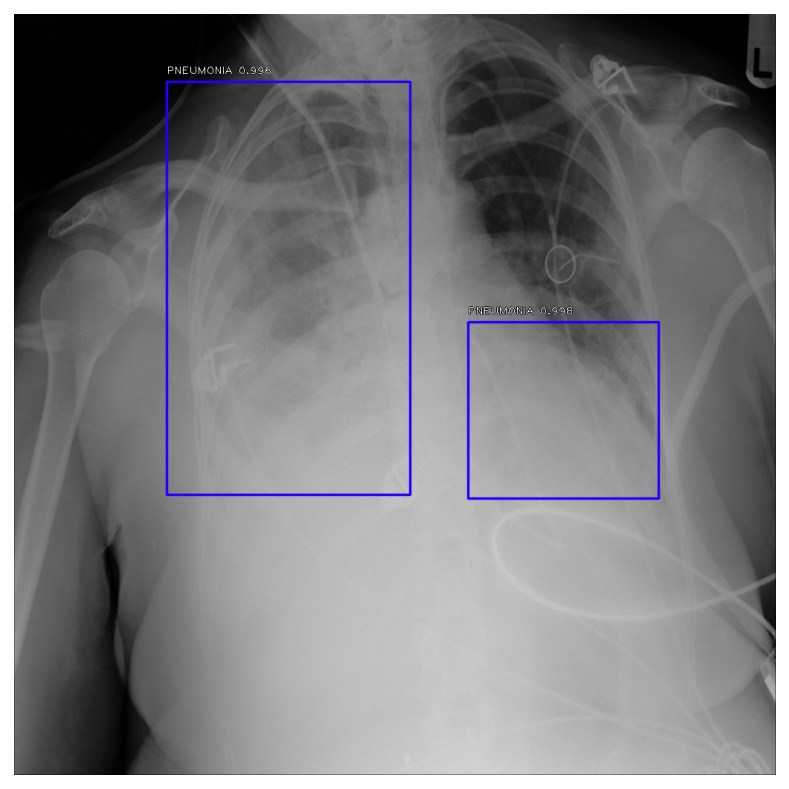

1

In [ ]:
# Open saved model, and directly make the prediction with new data

with open('./'+filename ,'rb') as f:
    loaded_pipe = dill.load(f)
loaded_pipe[1].loadModel(saved_model_file)
loaded_pipe.predict(jpg_path)

- We have reloaded the pickle file and predicting on the loaded data as counter check.

# Test samples

In [ ]:
#PNEUMONIA case
test_df[test_df['class_id'] == 0].head().path.to_numpy()

array(['stage_2_train_images/378ef52a-cbc7-4e92-bd6b-ecb4045508f3.dcm',
       'stage_2_train_images/8d09cad6-5aec-48fc-8c66-1b5e7c144ac8.dcm',
       'stage_2_train_images/dc506eb1-ef59-41e8-aebd-5c2a80026ba3.dcm',
       'stage_2_train_images/b75a77fe-d336-4c9f-994f-3d158521fa28.dcm',
       'stage_2_train_images/ed20cdc6-e8f7-4551-a8d5-6b360b3f9c71.dcm'],
      dtype=object)

In [ ]:
#Not Normal case
test_df[test_df['class_id'] == 1].head().path.to_numpy()

array(['stage_2_train_images/effc3b6b-4088-41e6-a06a-cfad22c0e1da.dcm',
       'stage_2_train_images/83fdefc4-082e-409d-80dd-7b043aed85ad.dcm',
       'stage_2_train_images/7200a1e9-eba0-4ced-bdd3-88544f162af0.dcm',
       'stage_2_train_images/ddc4c65f-8a3b-4446-aa52-6f9a78577dd3.dcm',
       'stage_2_train_images/e181104a-93bc-4289-a7b7-a651f79540e5.dcm'],
      dtype=object)

In [ ]:
#Normal case
test_df[test_df['class_id'] == 2].head().path.to_numpy()

array(['stage_2_train_images/b18e9b1c-e430-4200-8553-e585e0c49afc.dcm',
       'stage_2_train_images/55f2867a-5c49-4ea2-a9d7-9f8bb977222c.dcm',
       'stage_2_train_images/3ebf4e25-fb47-4040-a1f3-236fdad3e0f7.dcm',
       'stage_2_train_images/4de1459a-541e-4449-bbbd-38f829c4d4f5.dcm',
       'stage_2_train_images/4da6faee-c4af-4ea4-84a3-7c5733bfd249.dcm'],
      dtype=object)

- These are samples from each class for testing the unpickle notebook/production model.